# **Burn Injury Classifier**

According to the [World Health Organization](https://www.who.int/news-room/fact-sheets/detail/burns), an estimated 180,000 deaths per year are caused by burn injuries, with the vast majority occuring in low to middle-income nations. These injuries can be devestating and can have severe long-term consequences in victims. Emergency and Medical practicioners classify these injuries into [first, second, or third degree burns](https://stanfordhealthcare.org/medical-conditions/skin-hair-and-nails/burns/stages.html#:~:text=Burns%20are%20classified%20as%20first,they%20penetrate%20the%20skin's%20surface.&text=First%2Ddegree%20burns%20affect%20only,or%20outer%20layer%20of%20skin.) depending on how deeply they penetrate the skin's surface. This image classification model, trained on a [dataset](https://www.kaggle.com/datasets/shubhambaid/skin-burn-dataset) of patient images, aims to aid in rapidly and accurately identifiying the severity of a burn wound from an image of it.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import pathlib
from tensorflow.keras.optimizers.legacy import SGD

### Loading Data

In [9]:
data_dir = pathlib.Path('Images').with_suffix('')

In [10]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

269


### Splitting Data

In [12]:
batch_size = 16
img_height = 180
img_width = 180

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=10,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 271 files belonging to 4 classes.
Using 217 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=10,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 271 files belonging to 4 classes.
Using 54 files for validation.


Divides the images into 2 subsets:

Training set - used to train the model

Validation set - intermediary set used for fine-tuning the model and preventing overfitting; while training, it periodically helps assess how well the model generalizes to data it hasn't been trained on

### Visualizing Data (WARNING: GRAPHIC)

In [25]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3']


Classes: No Burn Injury, 1st Degree Burn, 2nd Degree Burn, 3rd Degree Burn

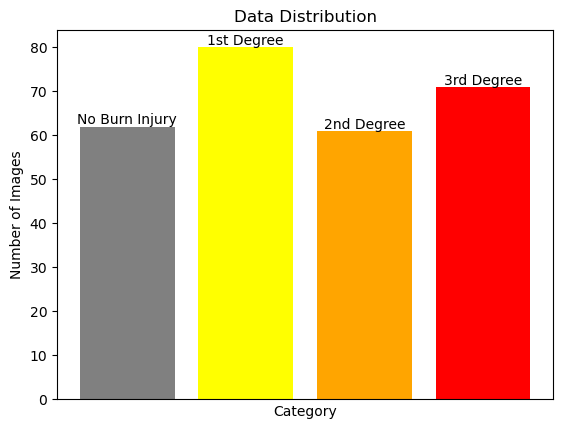

In [28]:
subdirectories = [os.path.join('Images', d) for d in os.listdir('Images') if os.path.isdir(os.path.join('Images', d))]
counts = [0] * len(subdirectories)
for i, directory in enumerate(subdirectories):
    counts[i] = len(os.listdir(directory))
container=plt.bar(subdirectories, counts, color=['gray', 'yellow', 'orange', 'red'])
plt.xticks([],rotation=90)
plt.ylabel("Number of Images")
plt.xlabel("Category")
plt.bar_label(container=container, labels=['No Burn Injury', '1st Degree', '2nd Degree', '3rd Degree'])
plt.title("Data Distribution")
plt.show()

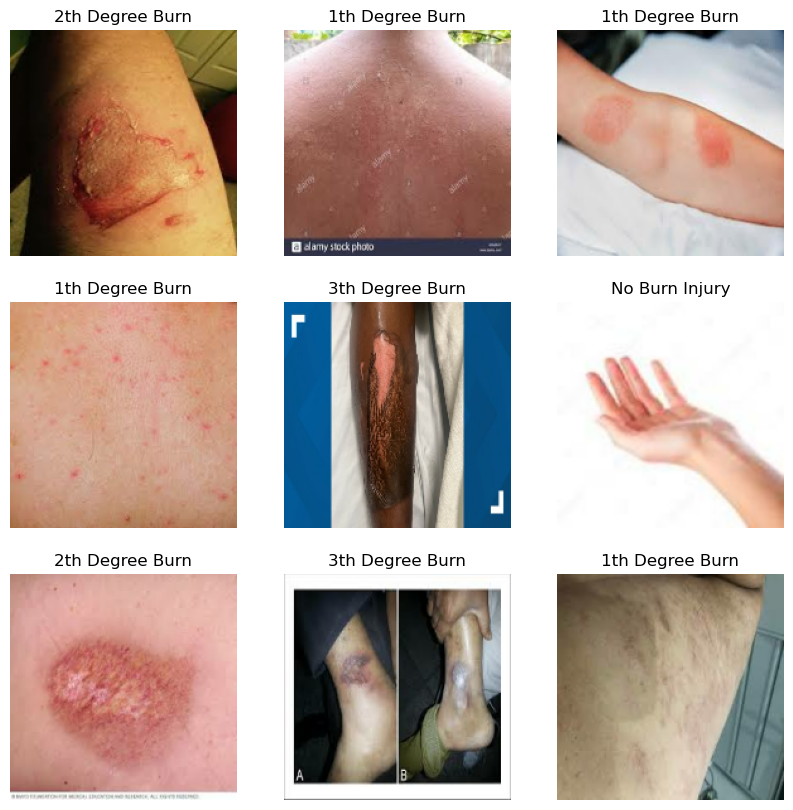

In [80]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    if class_names[labels[i]]=='1' or class_names[labels[i]]=='2' or class_names[labels[i]]=='3':
        plt.title(str(class_names[labels[i]])+'th Degree Burn')
    else:
        plt.title('No Burn Injury')
    plt.axis("off")

### Augmenting Data

Due to the small size of the dataset being used, data augmentation will allow for artificially increasing the size/diversity of the training set by making small changes to the original images. This way, every epoch that the model trains for, it will be training on slightly modified images. For this model, Keras layers are added to randomly flip the images horizontally and vertically and to randomly rotate them up to 20 degrees.

In [21]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.RandomFlip("vertical", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.RandomRotation(0.2)
  ]
)

### Transfer Learning and Fine Tuning

Once again, due to the small size of the dataset, transfer learning and fine-tuning will be employed to increase the effectiveness of the model. Rather than training completely from scratch, this model will incorporate its upper layers from ResNet-50, a convolutional neural network that has already been trained on the massive [ImageNet database](https://www.image-net.org/) and is consequently extremely effective at image classification. The model will inherit these weights and continue the training process on its much smaller Burn Injury Images Dataset.

In [24]:
model=tf.keras.Sequential()
pretrained_model=tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(img_height, img_width, 3),
    classes=4,
    classifier_activation="softmax",
)

for layer in pretrained_model.layers:
    layer.trainable=False   

### Building Model

In [26]:
model.add(data_augmentation)
model.add(pretrained_model)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(24, activation='relu'))
model.add(tf.keras.layers.Dense(24, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

Dense Layers: regular neural network layer; 'dense' because each of its neurons are connected to every single neuron of the previous layer

Flatten Layers: convert multidimensional input into one-dimensional input

Dropout Layers: regularization technique used to prevent overfitting; randomly ignores or "drops out" a given percentage of layer outputs during training in order to prevent co-adaptation of neurons

Rectified Linear Unit (ReLU) Activation Function: piecewise linear function which directly outputs positive inputs and outputs zero for any non positive inputs( f(x) = max(0, x) ) 

Softmax Activation Function: logistic function generalized for multiple classes/dimenstions; assigns decimal probabilities to each class

In [32]:
opt = SGD(learning_rate=0.01)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics=['accuracy'])

The Stochastic Gradient Descent (SGD) Optimizer takes user-defined intitial learning rate (global lr) and uses that learning rate uniformly for each step of training.

### Model Summary

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 6, 6, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 24)                1769496   
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 4)                

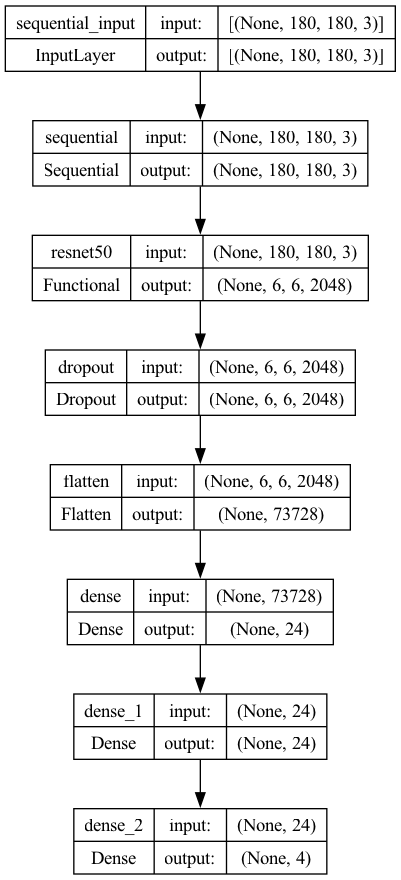

In [36]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True,
    show_layer_names=True,
)

### Training Model

In [38]:
my_callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1)
num_epochs=100
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds, callbacks=my_callbacks)

Epoch 1/100
14/14 [==============================] - 8s 470ms/step - loss: 3.8563 - accuracy: 0.2535 - val_loss: 1.4024 - val_accuracy: 0.2407
Epoch 2/100
14/14 [==============================] - 6s 438ms/step - loss: 1.3347 - accuracy: 0.2995 - val_loss: 1.2131 - val_accuracy: 0.3333
Epoch 3/100
14/14 [==============================] - 6s 426ms/step - loss: 1.2356 - accuracy: 0.4516 - val_loss: 1.0727 - val_accuracy: 0.4815
Epoch 4/100
14/14 [==============================] - 7s 487ms/step - loss: 1.1629 - accuracy: 0.5023 - val_loss: 1.1015 - val_accuracy: 0.5000
Epoch 5/100
14/14 [==============================] - 7s 474ms/step - loss: 1.1414 - accuracy: 0.5253 - val_loss: 1.0195 - val_accuracy: 0.5000
Epoch 6/100
14/14 [==============================] - 7s 499ms/step - loss: 1.0835 - accuracy: 0.5622 - val_loss: 1.0493 - val_accuracy: 0.5000
Epoch 7/100
14/14 [==============================] - 6s 441ms/step - loss: 1.0234 - accuracy: 0.5899 - val_loss: 0.9611 - val_accuracy: 0.5185

### Evaluating Model

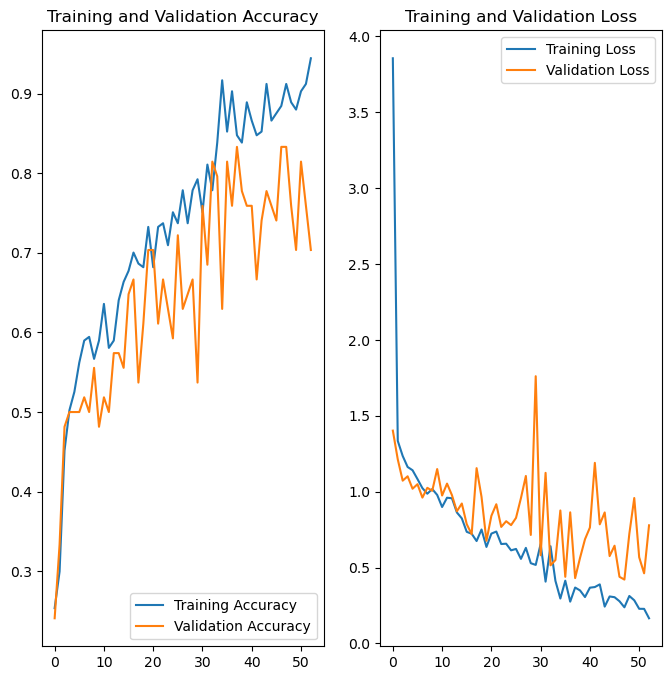

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The value of the loss function at a given epoch quantifies the difference between the predicted outputs of the algorithm and the actual target values; in other words, it is the penalty for a incorrect prediction magnified by how incorrect the prediction was.

Accuracy is a metric used to measure how often the model correctly predicts the outcome; Acc = # Correct Predictions / # Total Predictions.

The validation loss and validation accuracy values resulting from applying the model on the testing set indicate that the algorithm is reasonably effective at predicting the severity of burn injuries from images. However, the small size of the dataset and the lack of available data to increase it inhibited the model from reaching a higher accuracy. Despite the implementation of data augmentation, transfer learning, regularization, and hours of hyperparameter tuning, I was unable to get a validation accuracy above 83%. If a larger dataset becomes available, I hope to update and improve the model.

### Testing Model

Test Image:


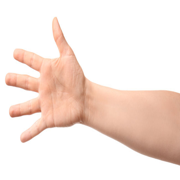

1/1 [==============================] - 0s 86ms/step
This image is most likely not a burn injury with a 40.21 percent confidence.



Test Image:


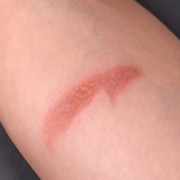

1/1 [==============================] - 0s 48ms/step
This image is most likely a first degree burn injury with a 43.13 percent confidence.



Test Image:


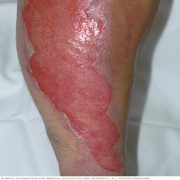

1/1 [==============================] - 0s 47ms/step
This image is most likely a second degree burn injury with a 43.36 percent confidence.



Test Image:


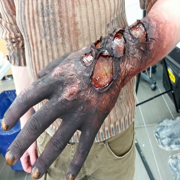

1/1 [==============================] - 0s 51ms/step
This image is most likely a third degree burn injury with a 47.31 percent confidence.





In [86]:
from PIL import Image
from IPython.display import display

example_images=['NormalExample.jpg', 'FirstDegreeExample.jpg', 'SecondDegreeExample.jpg', 'ThirdDegreeExample.jpg']
classes=['not a burn injury', 'a first degree burn injury', 'a second degree burn injury', 'a third degree burn injury']
for img_path in example_images:
    print("Test Image:")
    im = Image.open(img_path).resize((img_height, img_width))
    display(im)
    img = tf.keras.utils.load_img(
        img_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image is most likely {} with a {:.2f} percent confidence.\n\n\n"
        .format(classes[np.argmax(score)], 100 * np.max(score))
    )